In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq
import ivac

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_format = "retina"

# Load data

In [6]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# currents
j_du_ds = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_ds_3.npy", allow_pickle=True)[
    6
]  # 10 ns lag time
j_du_sb = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_sb_3.npy", allow_pickle=True)[
    6
]
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

Currents computed in `dga_220325.ipynb` 

In [7]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

# Reactive currents

In [8]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [9]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    n_pmf,
    clines,
    cm_pmf="macaw",
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    xlim = np.linspace(xmin, xmax, n_pmf)
    ylim = np.linspace(ymin, ymax, n_pmf)
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    pmf = extq.projection.density2d(cv1, cv2, weights, xlim, ylim)

    if ax is None:
        ax = plt.gca()
    ax, pc = plotting.plot_pmf(
        ax, pmf, xlim, ylim, units="kcal", clines=clines, cmap=cm_pmf
    )
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.007,
        cmap=cm_j,
        headwidth=2.5,
        headlength=2.5,
        headaxislength=2.5,
        scale=20,
        scale_units="width",
        zorder=5,
    )

    return ax, pc, quiv

/project/dinner/scguo/ci-vsd/notebooks/figures/../../python/plotting.py:147: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy
/scratch/local/jobs/4448406/ipykernel_711411/4248205377.py:65: RuntimeWarning: invalid value encountered in true_divide
  (jx_binned / col).T,
/scratch/local/jobs/4448406/ipykernel_711411/4248205377.py:66: RuntimeWarning: invalid value encountered in true_divide
  (jy_binned / col).T,
/scratch/local/jobs/4448406/ipykernel_711411/425019081.py:47: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7ff504dbbc70> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/4448406/ipykernel_711411/425019081.py:47: UserWarning: The handle <matplotlib.quiver.Quiver object at 0x7ff504533430> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


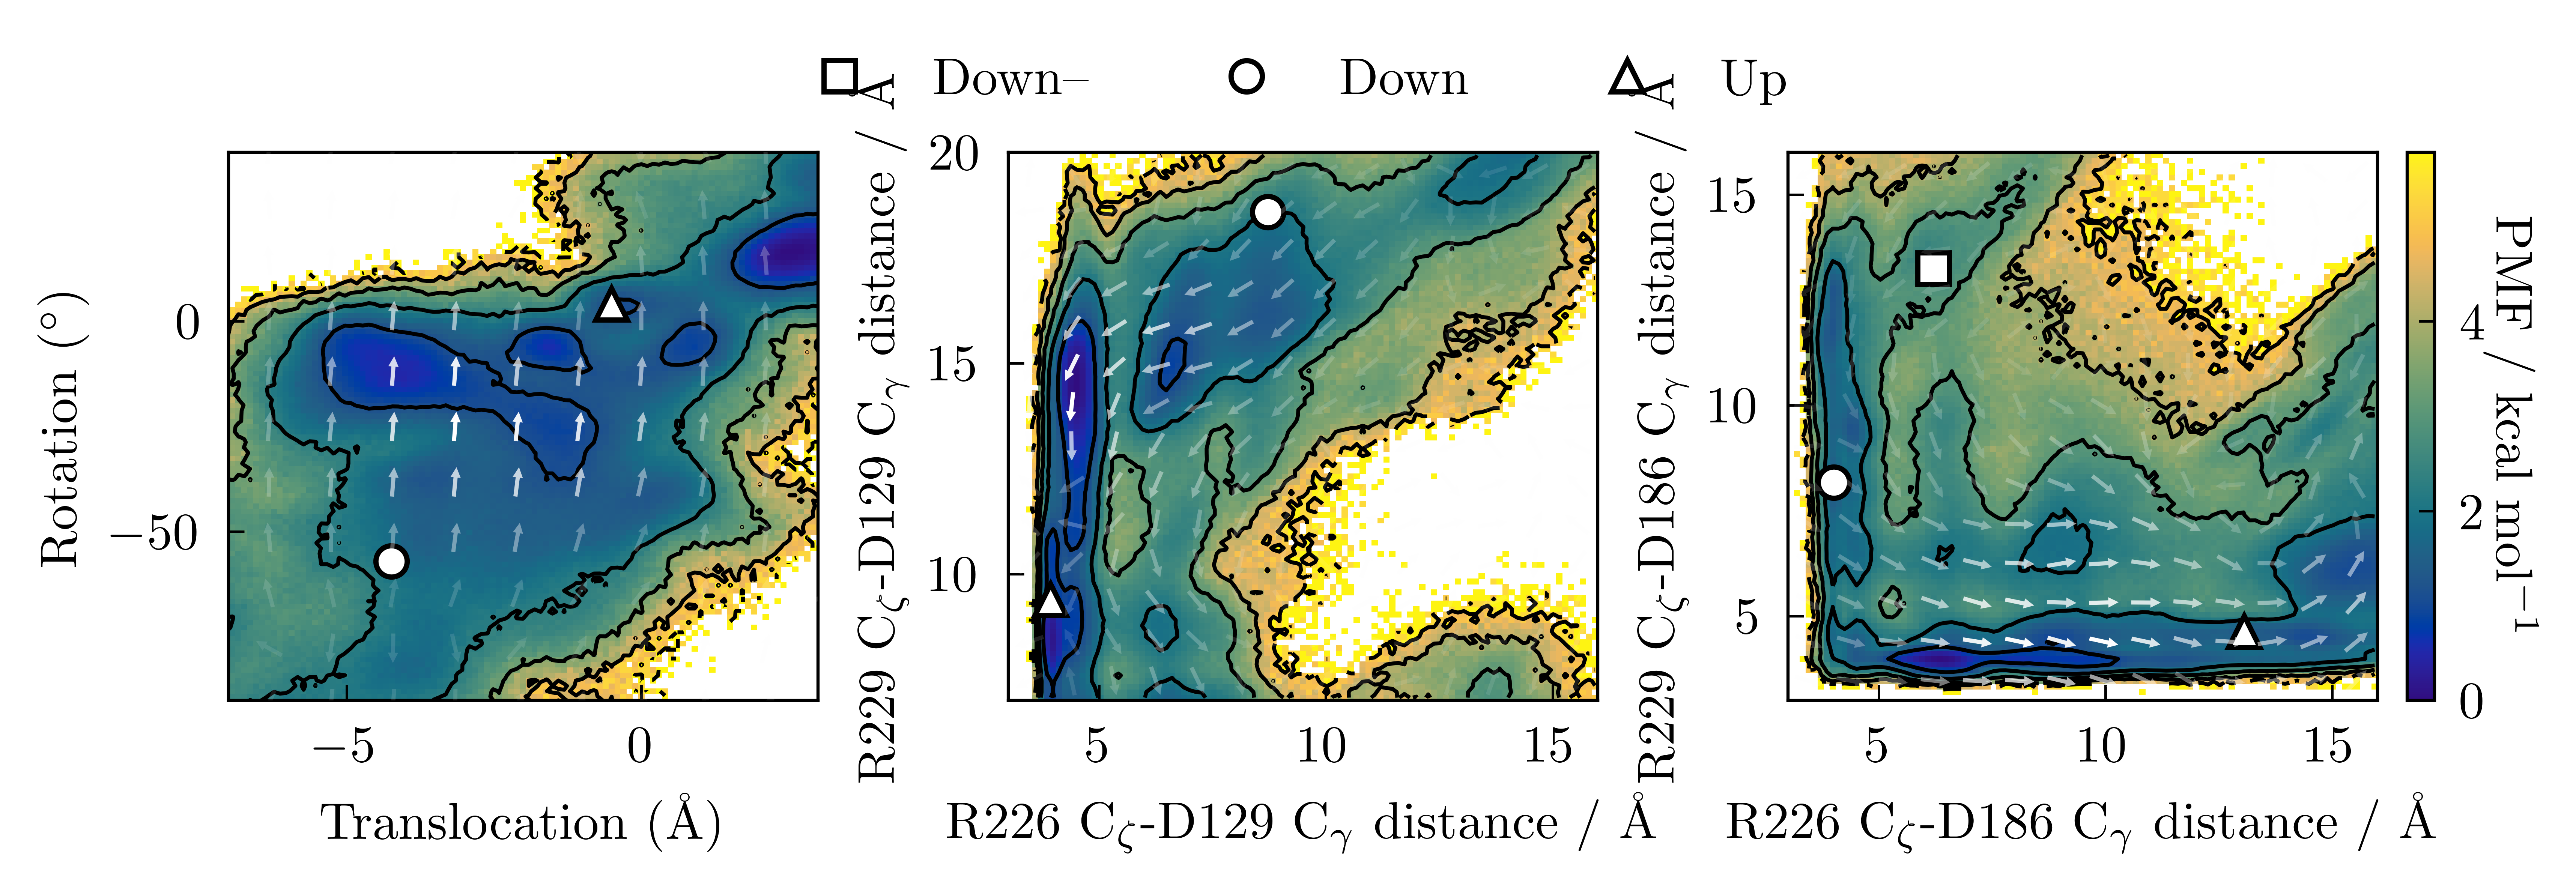

In [10]:
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
clines = np.linspace(0, 6, 7)

f, (ax0, ax1, ax2) = plt.subplots(
    1, 3, figsize=(6.75, 2), dpi=500, constrained_layout=True
)
ax0, pc, quiv = plot_current(
    dist_trajs, rot_trajs, j_du_ds, weights, -10, 10, -150, 100, 19, 200, clines, ax=ax0
)

plotting.format_cvs(ax0, centroids=True, ms=6)
ax0.set(xlim=[-7, 3], ylim=[-90, 40])

sb_ids = [42, 48, 47, 53]
range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
for ((i, j), ax, r) in zip(((0, 1), (2, 3)), (ax1, ax2), (range0, range1)):
    sb_id0 = sb_ids[i]
    sb_id1 = sb_ids[j]
    sb0_trajs = [t[:, sb_id0] * 10 for t in sb_trajs]  # in Angstroms
    sb1_trajs = [t[:, sb_id1] * 10 for t in sb_trajs]
    ax, pc, quiv = plot_current(
        sb0_trajs,
        sb1_trajs,
        j_du_sb[:, [i, j]],
        weights,
        *r[0],
        *r[1],
        14,
        100,
        clines,
        ax=ax,
    )
    ax.set(
        xlabel=f"{sb_names[sb_id0]} distance / Å",
        ylabel=f"{sb_names[sb_id1]} distance / Å",
        xlim=r[0],
        ylim=r[1],
    )

cb2 = plt.colorbar(pc, ax=ax2)
cb2.set_label("PMF / kcal mol$^{-1}$", rotation=-90, labelpad=10)
plotting.plot_models(ax1, sb_models[:, [42, 48]] * 10, ms=6)
plotting.plot_models(ax2, sb_models[:, [47, 53]] * 10, ms=6)

f.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="center",
    ncol=3,
    labels=["_", "_", "Down–", "Down", "Up"],
)
# plt.savefig("../../fig/paper/fig_s2_current.png", bbox_inches="tight")

/project/dinner/scguo/ci-vsd/notebooks/figures/../../python/plotting.py:147: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy
/scratch/local/jobs/4725242/ipykernel_1189610/626918126.py:35: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f3d1b7545e0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/4725242/ipykernel_1189610/626918126.py:35: UserWarning: The handle <matplotlib.quiver.Quiver object at 0x7f3d19ae0820> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/4725242/ipykernel_1189610/626918126.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f3d19600a30> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


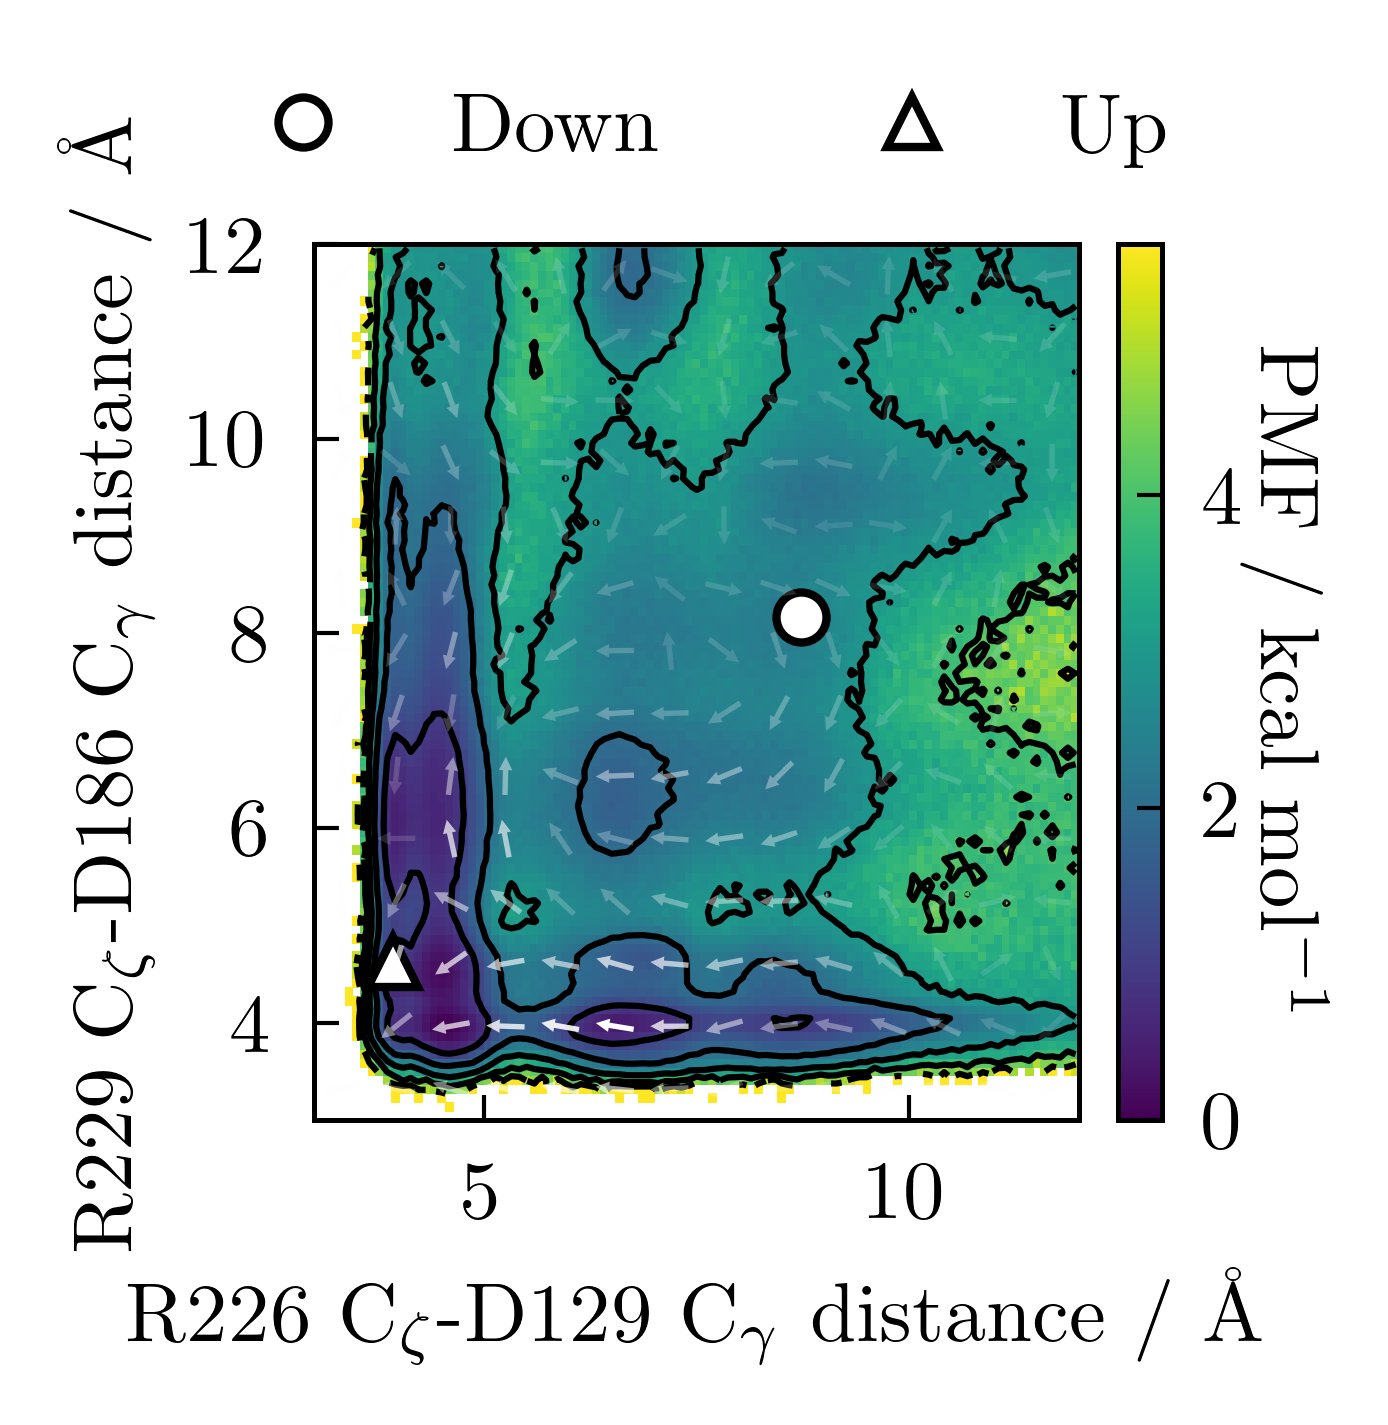

In [21]:
clines = np.linspace(0, 6, 7)

f, ax = plt.subplots(figsize=(2.2, 2), dpi=300, constrained_layout=True)

sb_ids = [42, 48, 47, 53]
range0 = [[3, 12], [3, 12]]
sb_id0 = sb_ids[0]
sb_id1 = sb_ids[3]
sb0_trajs = [t[:, sb_id0] * 10 for t in sb_trajs]  # in Angstroms
sb1_trajs = [t[:, sb_id1] * 10 for t in sb_trajs]
ax, pc, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_du_sb[:, [0, 3]],
    weights,
    *range0[0],
    *range0[1],
    14,
    100,
    clines,
    ax=ax,
    cm_pmf='viridis'
)
ax.set(
    xlabel=f"{sb_names[sb_id0]} distance / Å",
    ylabel=f"{sb_names[sb_id1]} distance / Å",
    xlim=range0[0],
    ylim=range0[1],
)

cb2 = plt.colorbar(pc, ax=ax)
cb2.set_label("PMF / kcal mol$^{-1}$", rotation=-90, labelpad=10)
plotting.plot_models(ax, sb_models[:, [42, 53]] * 10, ms=6)

f.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="center",
    ncol=3,
    labels=["_", "_", "_", "Down", "Up"],
)

# Plot against committor

In [10]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [11]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [12]:
from extq.stop import forward_stop

In [13]:
# compute E[\theta(x) S_tq_+(x)]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [14]:
def plot_j(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

In [15]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [16]:
plt.rcParams["font.size"] = 8

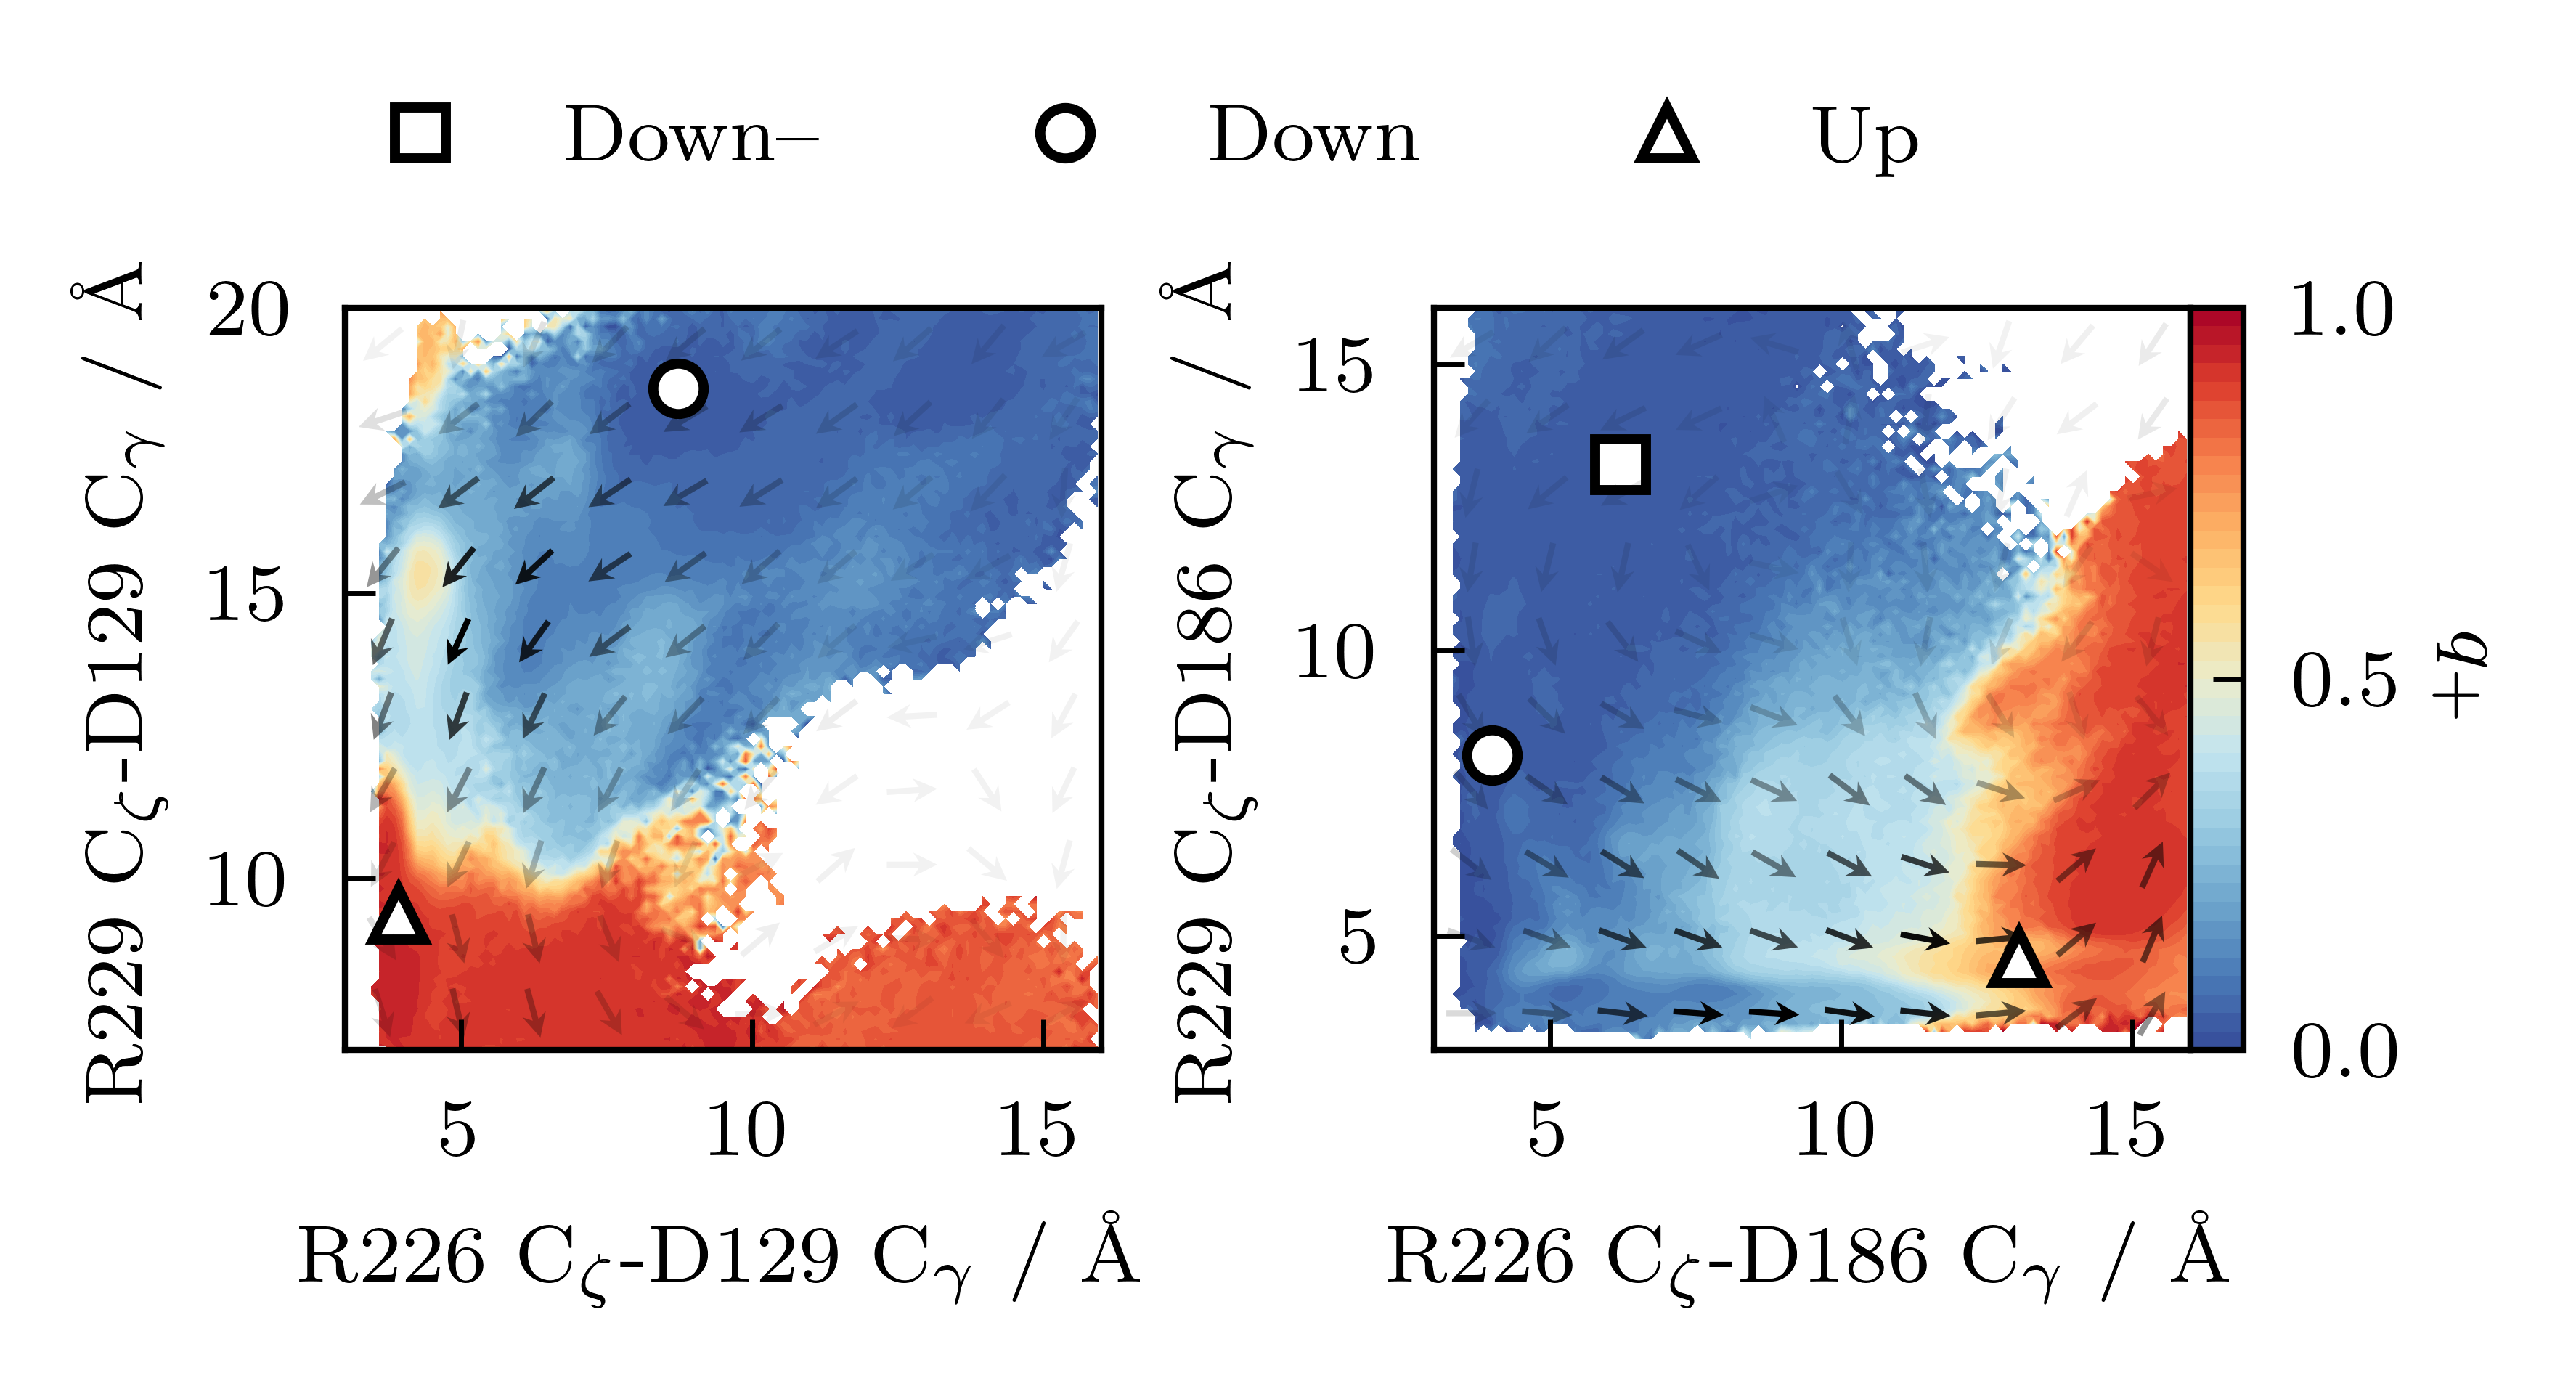

In [61]:
f, axes = plt.subplots(1, 2, figsize=(3.0, 1.5), dpi=500, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
sb_ids = [42, 48, 47, 53]
levels = np.linspace(0, 1, 41)

for ((i, j), ax) in zip(((0, 1), (2, 3)), axes):
    sb1, sb2 = sb_ids[i], sb_ids[j]
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5)
f.legend(
    bbox_to_anchor=(0.5, 1.1),
    loc="center",
    ncol=3,
    labels=["Down–", "Down", "Up"],
)
for ((i, j), ax, r) in zip(((0, 1), (2, 3)), axes, (range0, range1)):
    sb1, sb2 = sb_ids[i], sb_ids[j]
    sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
    sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    xc = (xlim[1:] + xlim[:-1]) / 2
    yc = (ylim[1:] + ylim[:-1]) / 2
    q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
    # h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
    h = ax.contourf(xc, yc, q_dens.T, levels=levels, cmap=cm_div)

    sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
    sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    ax, quiv = plot_j(
        sb0_trajs,
        sb1_trajs,
        j_du_sb[:, [i, j]],
        weights,
        *r[0],
        *r[1],
        10,
        ax=ax,
        cm_j="black",
    )
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )

axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])
cb = pplt.colorbar(h)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 1, 3))

/scratch/local/jobs/4725242/ipykernel_1189610/2630759055.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f3d19231490> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


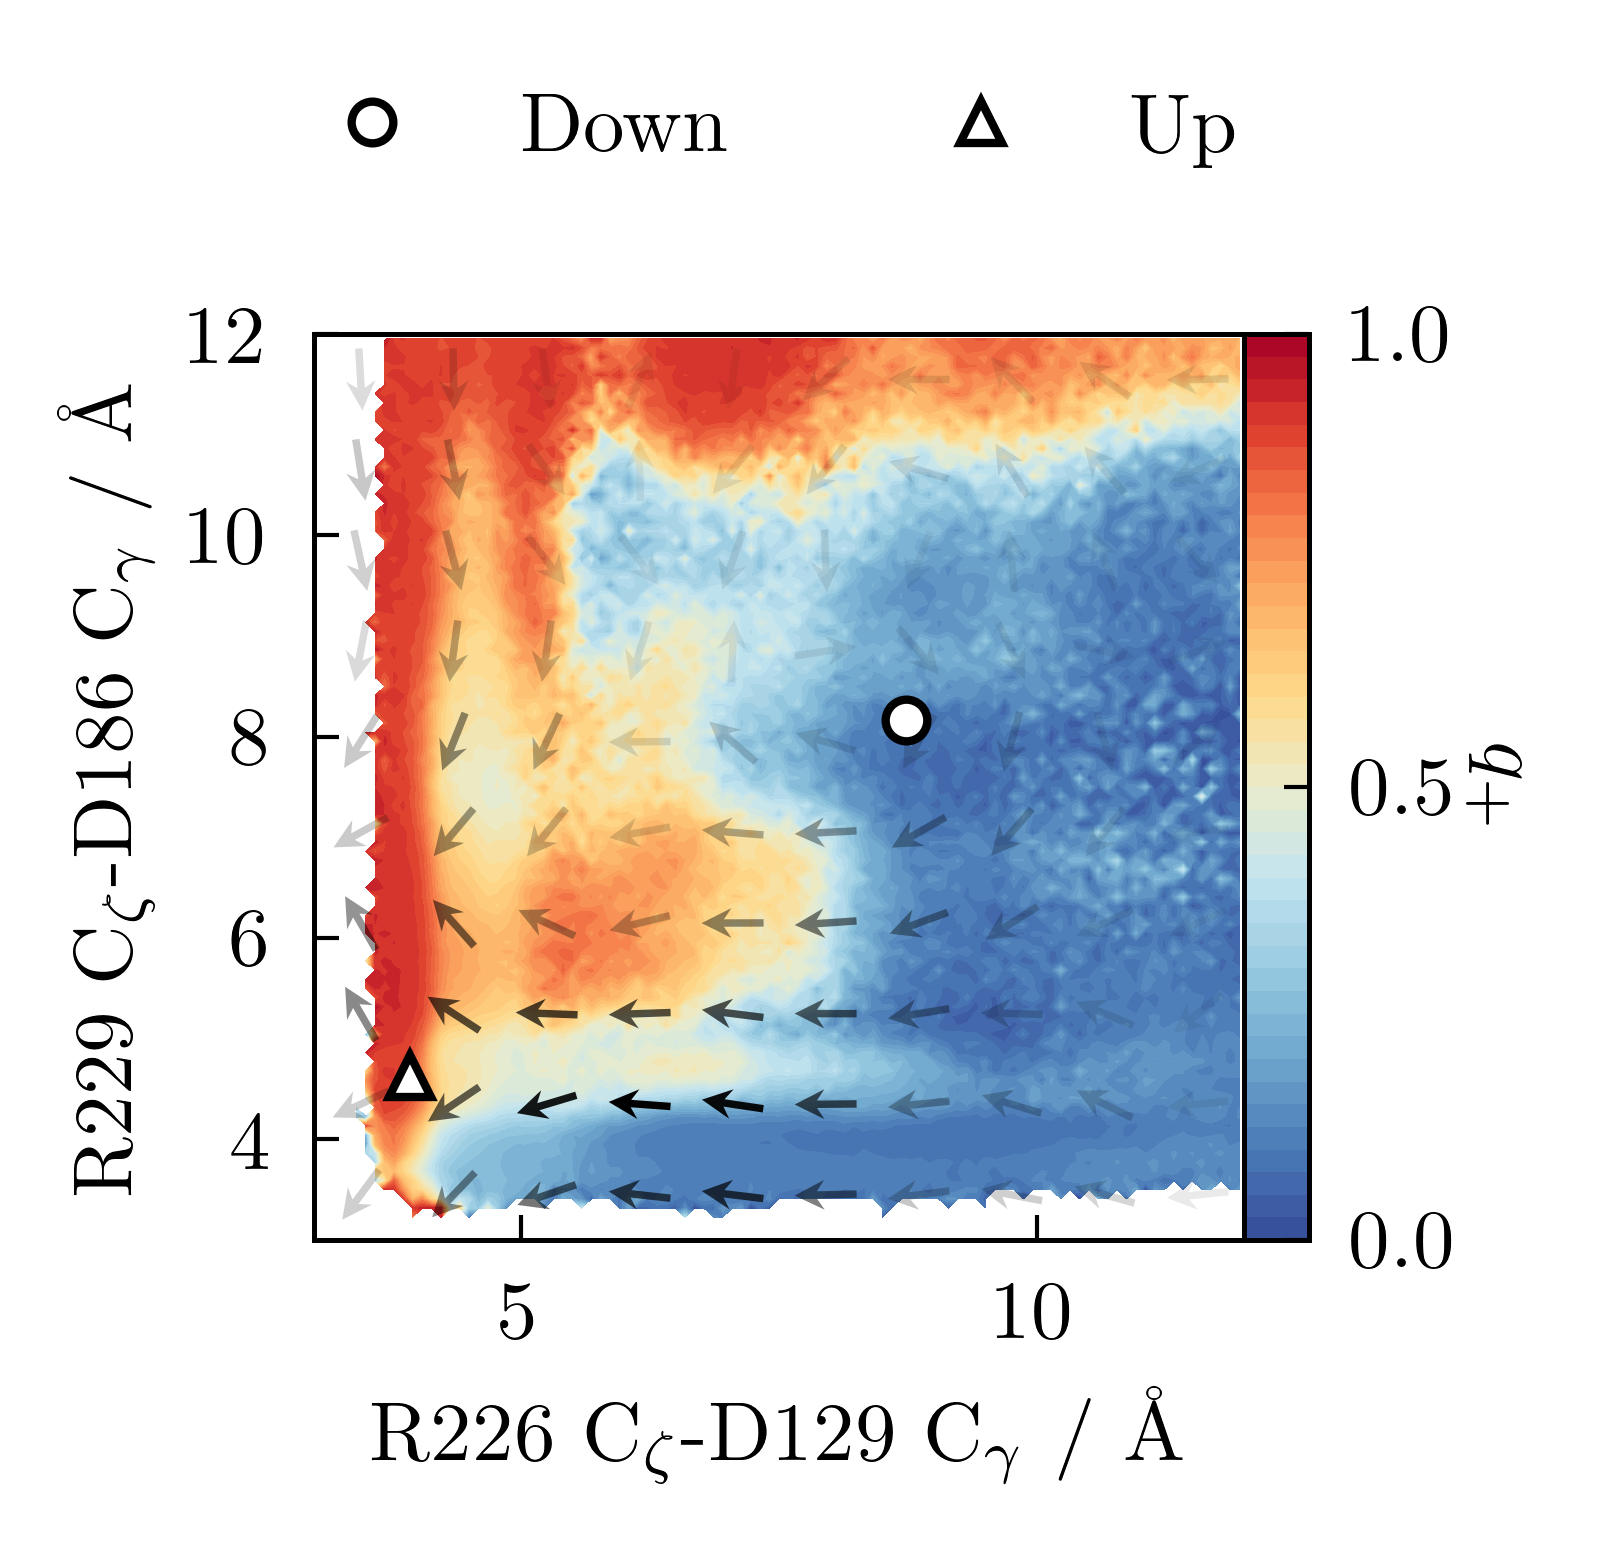

In [23]:
f, ax = plt.subplots(figsize=(2, 2), dpi=300)

range0 = [[3, 12], [3, 12]]
nbin = 100
sb_ids = [42, 48, 47, 53]
levels = np.linspace(0, 1, 41)

sb1, sb2 = sb_ids[0], sb_ids[3]
plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5)
f.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="center",
    ncol=3,
    labels=["_", "Down", "Up"],
)
sb1, sb2 = sb_ids[0], sb_ids[3]
sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
xlim = np.linspace(*range0[0], nbin)
ylim = np.linspace(*range0[1], nbin)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2
q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
# h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
h = ax.contourf(xc, yc, q_dens.T, levels=levels, cmap=cm_div)

sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]
ax, quiv = plot_j(
    sb0_trajs,
    sb1_trajs,
    j_du_sb[:, [0, 3]],
    weights,
    *range0[0],
    *range0[1],
    10,
    ax=ax,
    cm_j="black",
)
ax.set(
    xlabel=f"{sb_names[sb1]} / Å",
    ylabel=f"{sb_names[sb2]} / Å",
)

ax.set(xlim=range0[0], ylim=range0[1])
cb = pplt.colorbar(h)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 1, 3))